In [1]:
import torch
torch.cuda.is_available()

True

In [36]:
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import numpy as np
plt.rcParams['figure.dpi']=400

colors = ['black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [28]:
def get_section_results(file, X_label='Train_EnvstepsSoFar', Y_label='Train_AverageReturn'):
    """
        requires tensorflow==1.12.0
    """
    X = []
    Y = []
    for e in tf.compat.v1.train.summary_iterator(file):
        for v in e.summary.value:
            if v.tag == X_label:
                X.append(v.simple_value)
            elif v.tag == Y_label:
                Y.append(v.simple_value)
    return X, Y

def getXY(exp_name, X_label='Train_EnvstepsSoFar', Y_label='Train_AverageReturn', X_max=float('inf')):
    logdir = '/home/harvey/Documents/cs285/CS285-Project/data/%s/events*'%exp_name
    eventfile = glob.glob(logdir)[0]
    X, Y = get_section_results(eventfile, X_label=X_label, Y_label=Y_label)
    assert(len(X) == len(Y))
    X, Y = [x for x in X if x<X_max], [Y[i] for i in range(len(X)) if X[i]<X_max]
    return X, Y

def getXYpeer(exp_name, X_label='Train_EnvstepsSoFar', Y_label='Train_AverageReturn', peer_num=10, X_max=float('inf')):
    result = []
    for i in range(peer_num):
        Xi, Yi = getXY(exp_name, "Agent%d_"%i+X_label, "Agent%d_"%i+Y_label, X_max=X_max)
        if Xi and Yi:
            result.append((Xi, Yi))
    return result

def getXYensemble(exp_name, X_label='Train_EnvstepsSoFar', Y_label='Train_AverageReturn', num_agents=None, X_max=float('inf')):
    X, Y = getXY(exp_name, X_label, Y_label, X_max=X_max)
    if not num_agents:
        num_agents = int(exp_name[exp_name.find('ensemble') + 9])
    result = []
    for i in range(num_agents):
        Xi, Yi = X[i::num_agents], Y[i::num_agents]
        result.append((Xi, Yi))
    return result

def check(exp_name):
    X, Y = getXY(exp_name)
    for i, (x, y) in enumerate(zip(X, Y)):
        print('Iteration {:d} | Train steps: {:d} | Return: {}'.format(i, int(x), y))

In [24]:
sacv1 = "sac_peer_2_agents_HalfCheetah-v4_11-12-2022_19-11-52"
sacv2 = "sac_peer_2_agents_v2_HalfCheetah-v4_11-12-2022_19-46-11"
ensemble2 = "sac_ensemble_2_agents_100k_iter_HalfCheetah-v4_13-12-2022_18-18-33"
ensemble3 = "sac_ensemble_3_agents_100k_iter_HalfCheetah-v4_13-12-2022_18-18-33"
ensemble5 = "sac_ensemble_5_agents_100k_iter_HalfCheetah-v4_13-12-2022_18-18-33"

baseline = "peersac_hw3q6_HalfCheetah_actorfreq10_HalfCheetah-v4_12-12-2022_23-41-31"
hw3q6 = "q6b_sac_HalfCheetah_actorfreq10_fixed2_HalfCheetah-v4_20-10-2022_13-00-19"
peerv2_3agents = "peersac_3agents_temp0.1_HalfCheetah-v4_13-12-2022_01-18-43"
peerv2_3agents_eps0p3 = "peersac_3agents_eps0.3_HalfCheetah-v4_13-12-2022_00-13-54"
peerv2_3agents_eps0p5 = "peersac_3agents_eps0.5_HalfCheetah-v4_13-12-2022_18-59-06"
peerv2_3agents_eps0p7 = "peersac_3agents_eps0.7_HalfCheetah-v4_14-12-2022_09-44-29"

peerv2_temp0p1 = "peersac_3agents_temp0.1_HalfCheetah-v4_13-12-2022_01-18-43"
peerv2_temp0p2 = "peersac_3agents_temp0.2_HalfCheetah-v4_13-12-2022_20-09-34"
peerv2_temp0p4 = "peersac_3agents_temp0.4_HalfCheetah-v4_14-12-2022_11-06-22"

peerv2_3agents = "peersac_3agents_HalfCheetah-v4_13-12-2022_01-23-03"
peerv2_5agents = "peersac__HalfCheetah-v4_13-12-2022_20-03-44"
# peerv2_2agents = "peersac_3agents_temp0.4_HalfCheetah-v4_14-12-2022_11-06-22"

default_2agents = "peersac_2agents_HalfCheetah-v4_14-12-2022_18-24-42"
default_3agents = "peersac_3agents_HalfCheetah-v4_13-12-2022_01-23-03"
default_5agents = "peersac_5agents_HalfCheetah-v4_13-12-2022_20-03-44"



### SAC Peer Learning HW3 comparison experiment

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


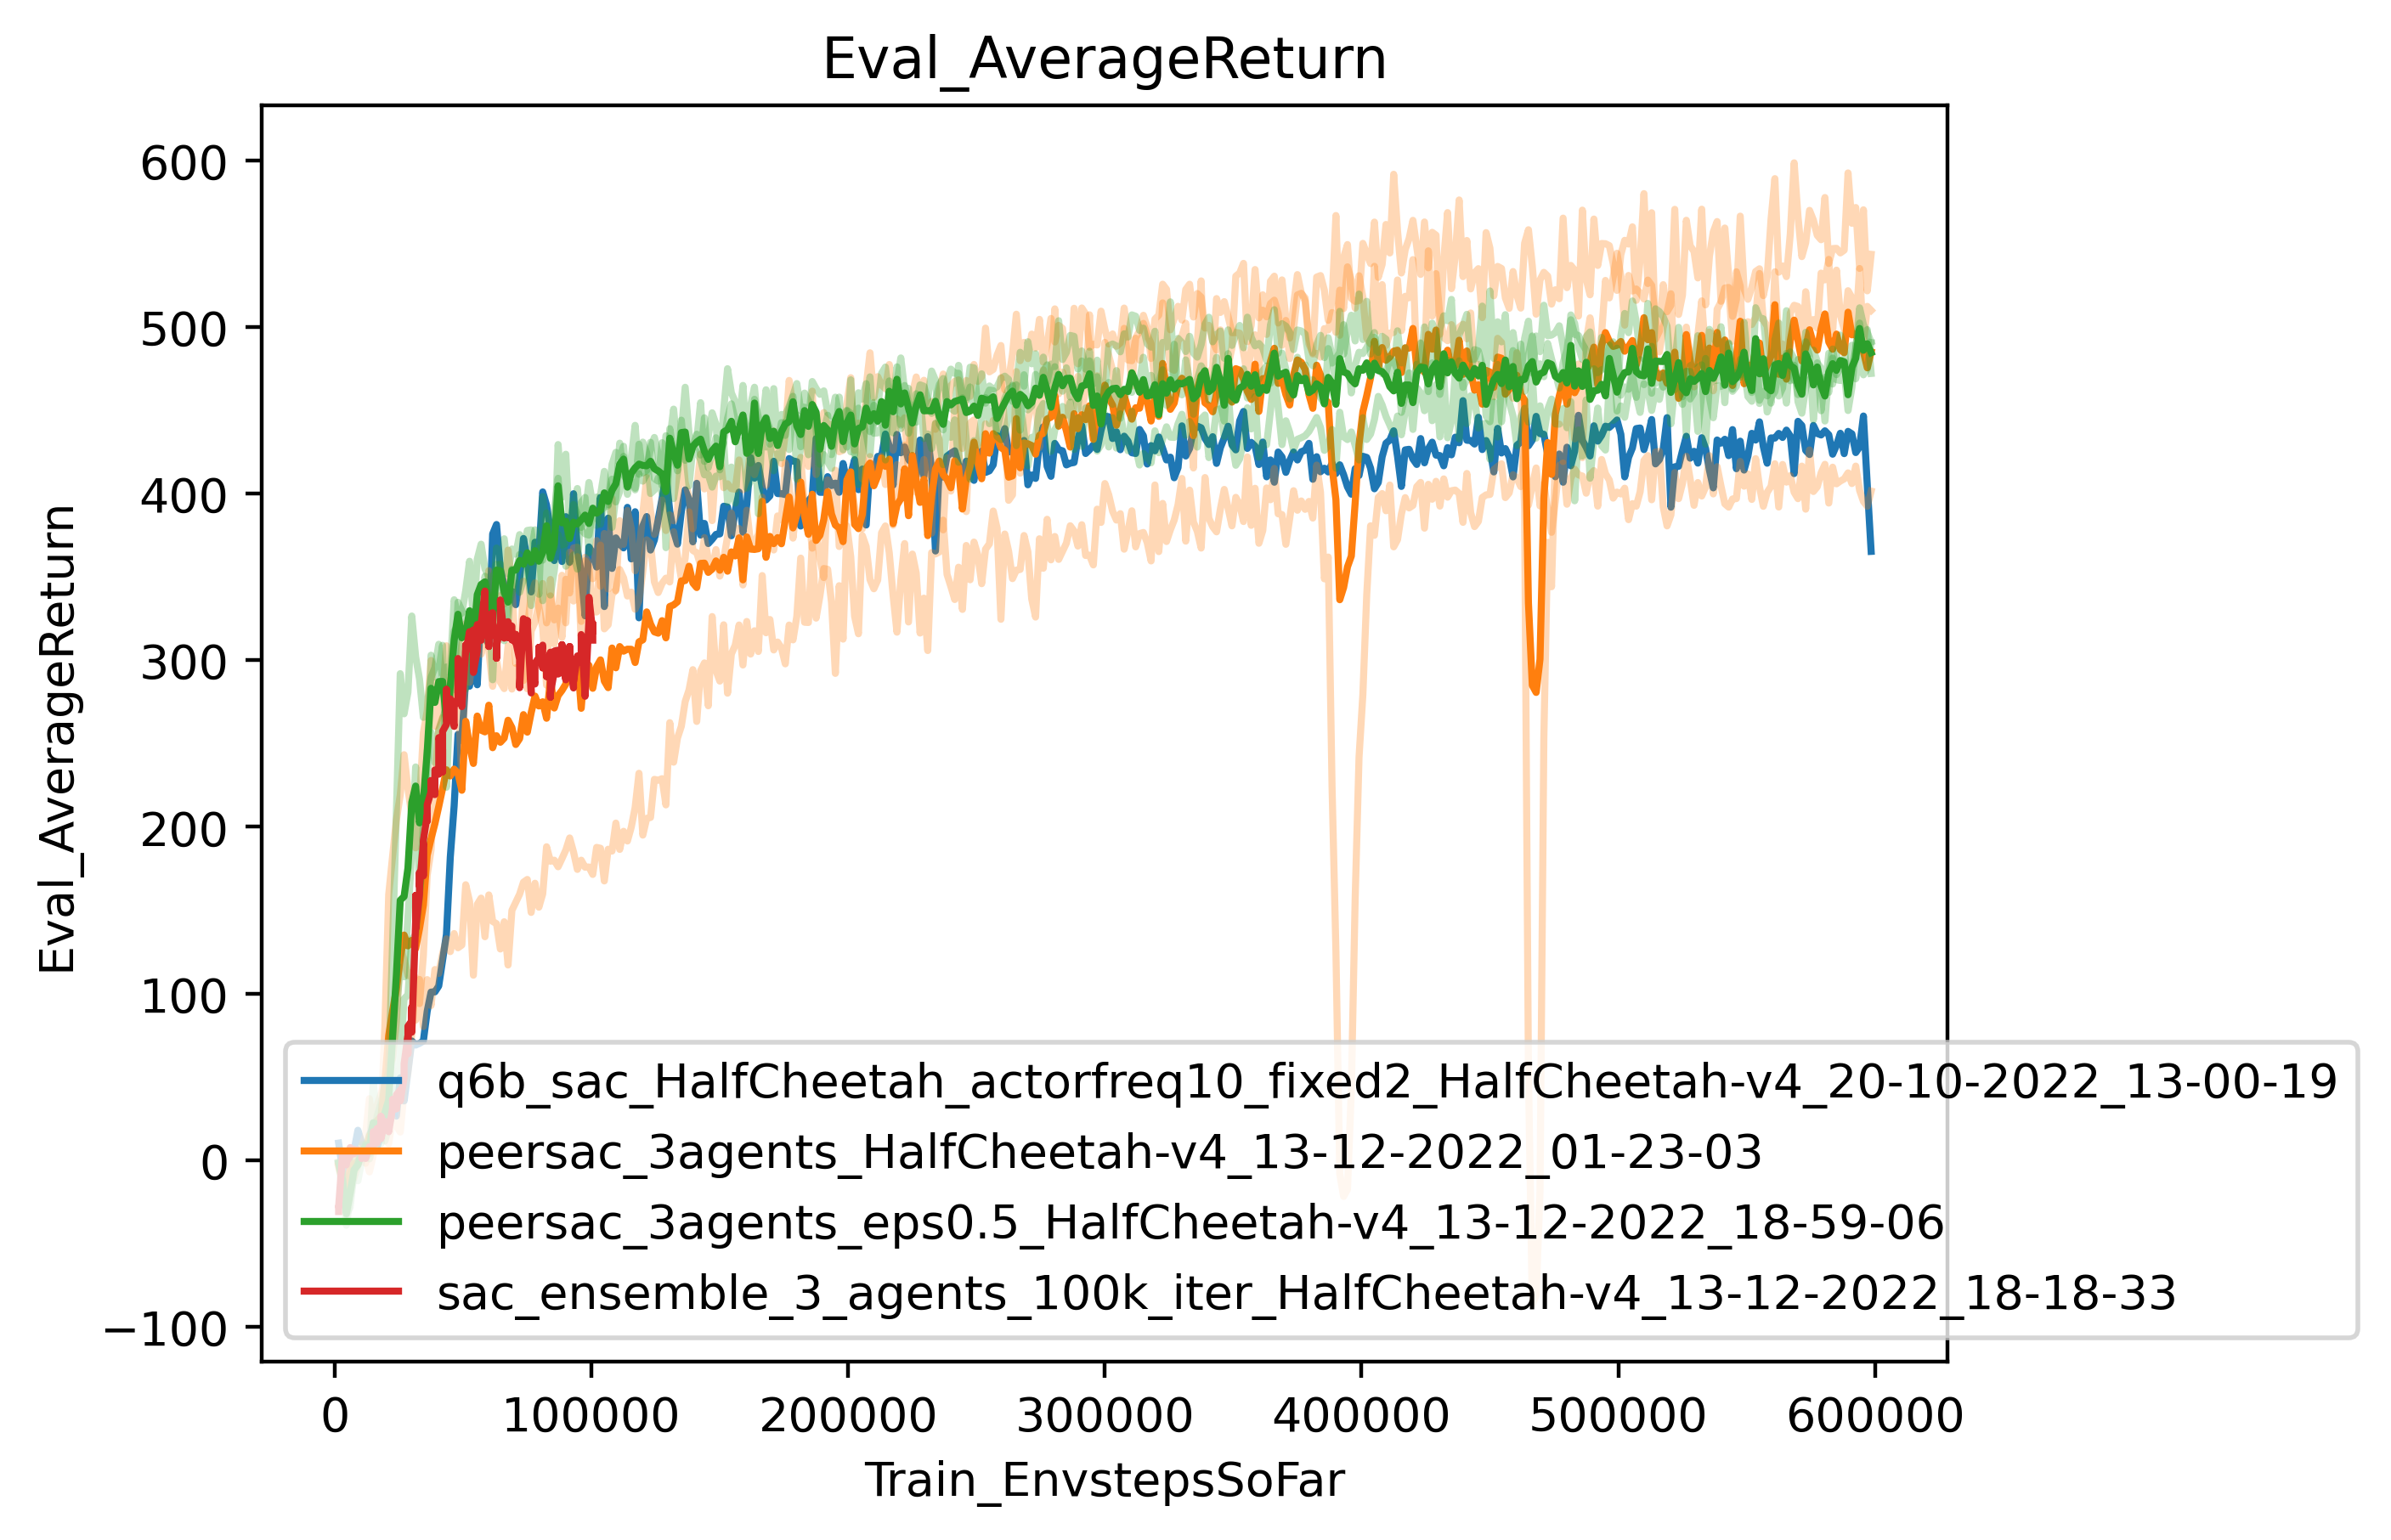

In [5]:
exp_names = [hw3q6, peerv2_3agents, peerv2_3agents_eps0p5, ensemble3] # 

X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = 0.6e6
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        Y_avg = np.mean([Y for X, Y in series], axis=0)
        plt.plot(X, Y_avg, label=exp_name, c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=exp_name, c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend()
plt.title("Eval_AverageReturn")
plt.show()

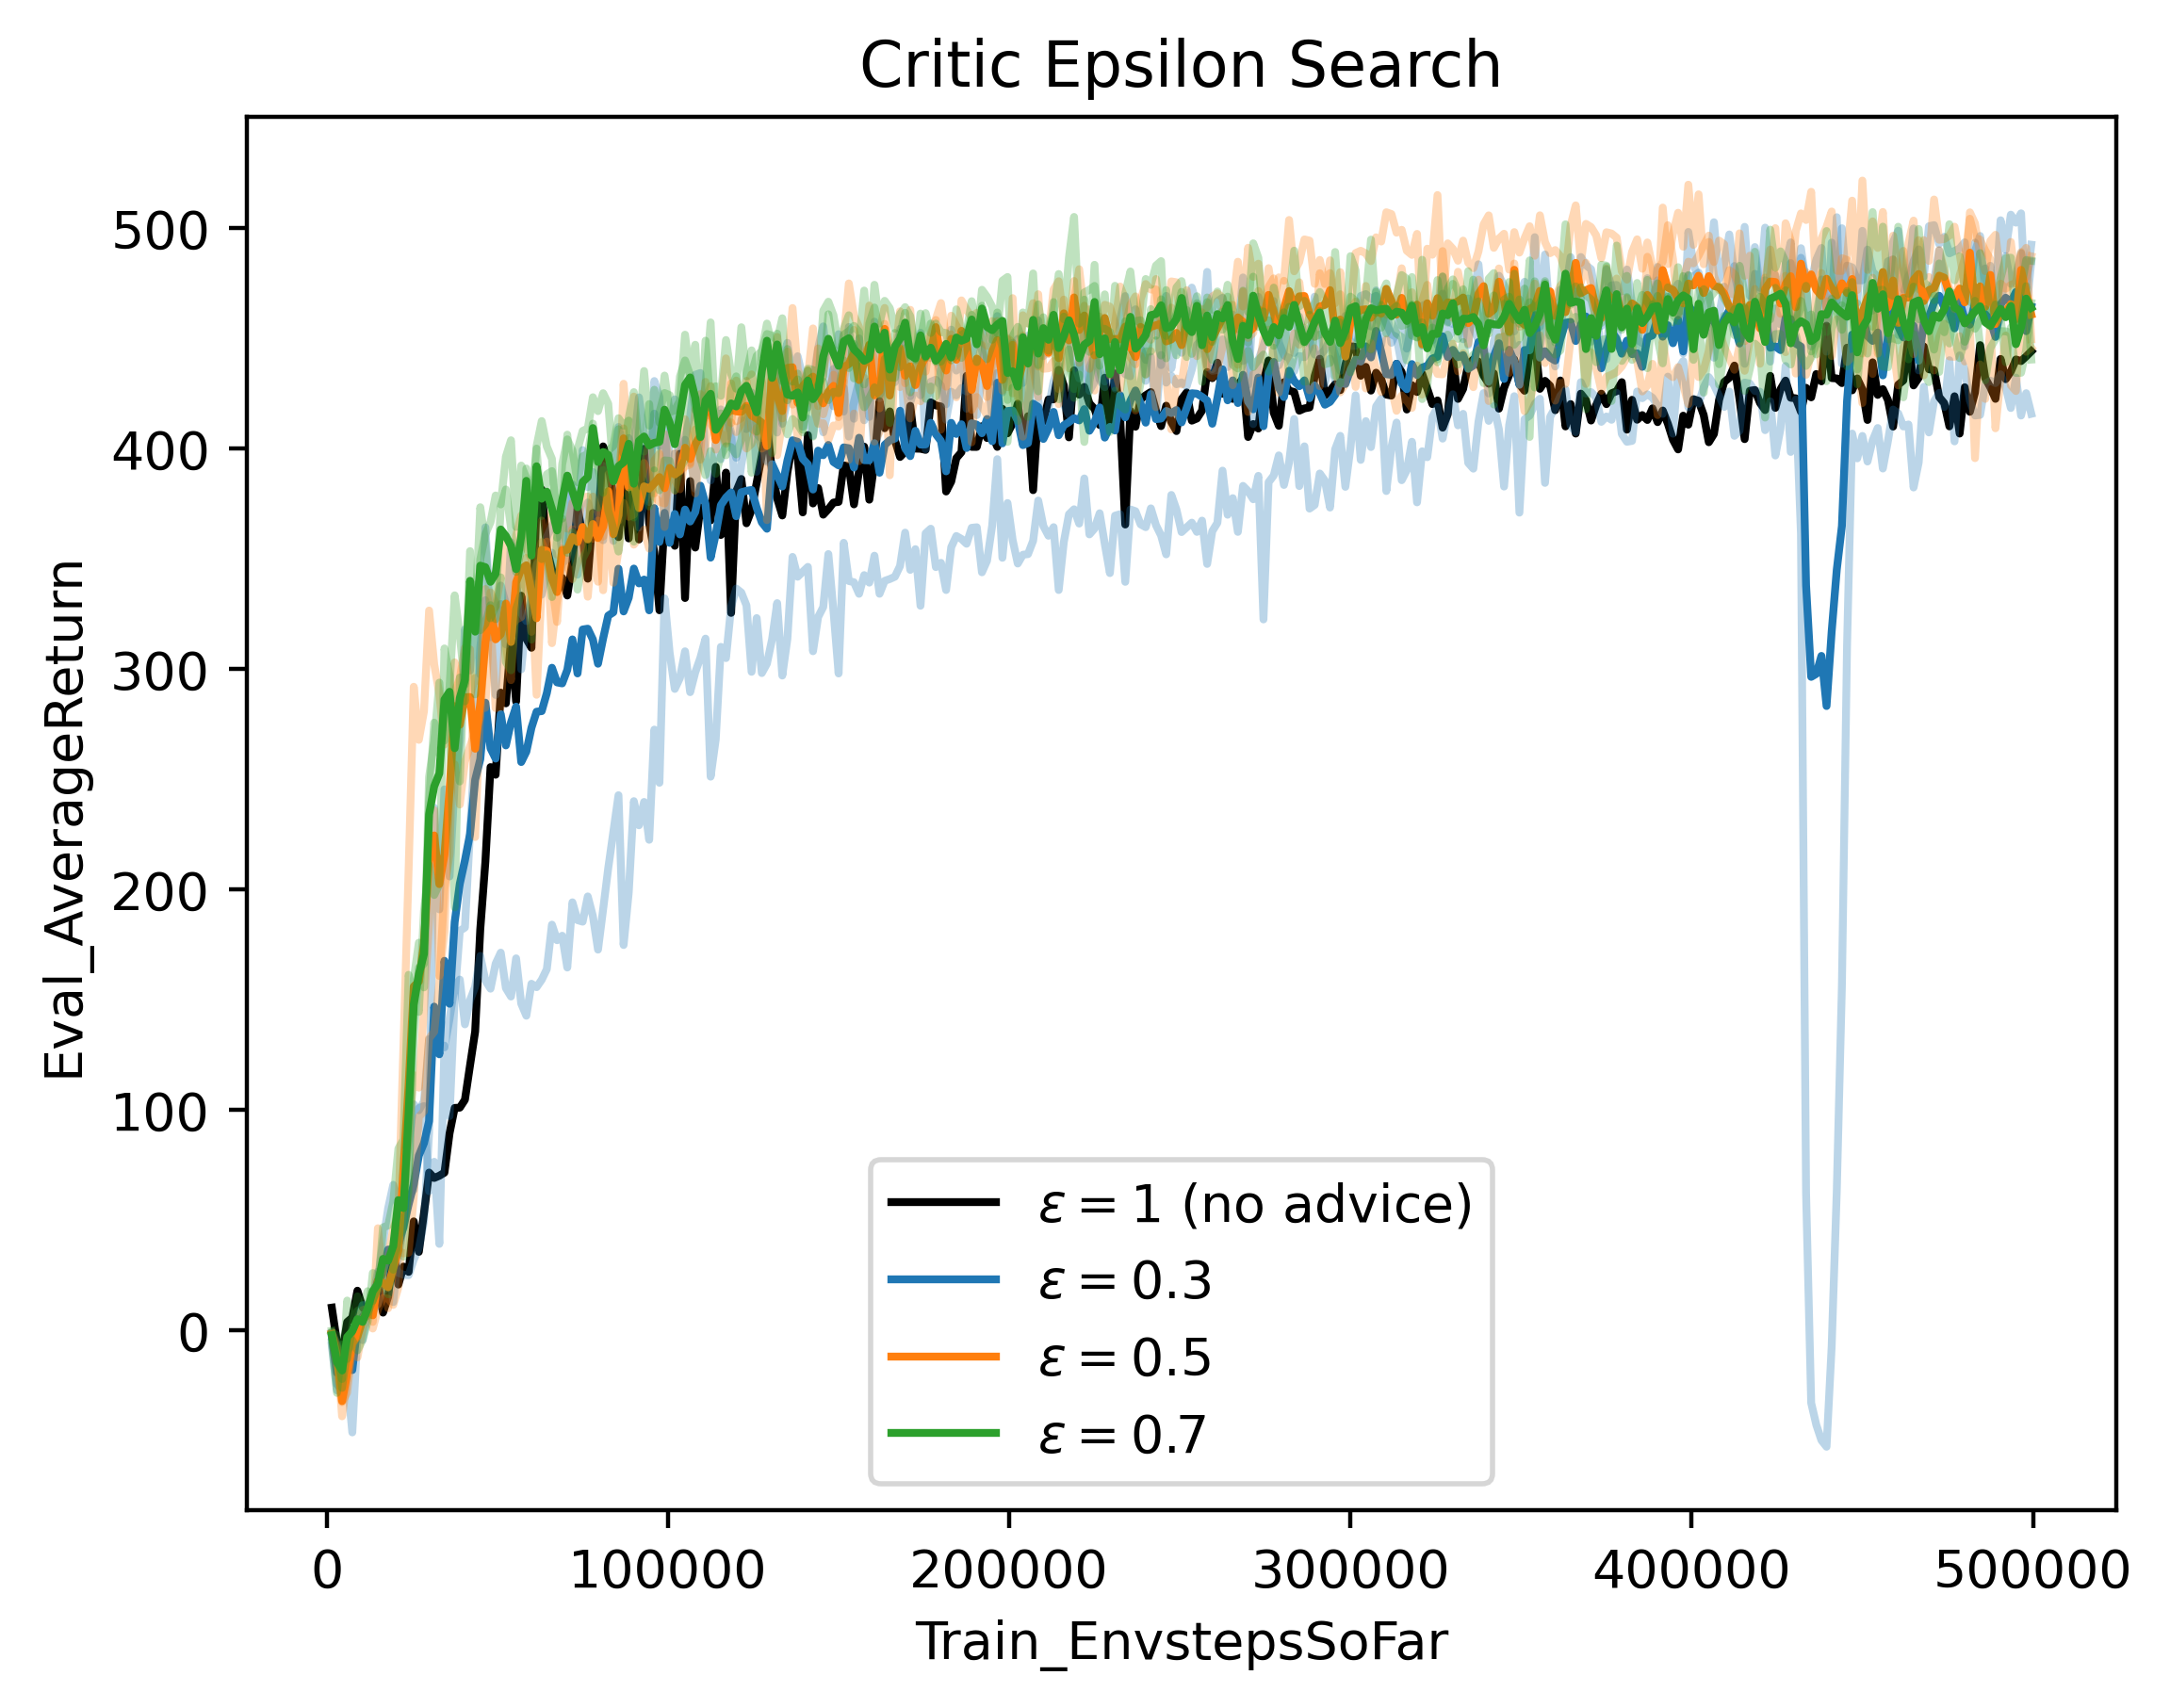

In [62]:
label_map = {
    hw3q6: r"$\epsilon = 1$ (no advice)",
    peerv2_3agents_eps0p3: r"$\epsilon = 0.3$",
    peerv2_3agents_eps0p5: r"$\epsilon = 0.5$",
    peerv2_3agents_eps0p7: r"$\epsilon = 0.7$",
    }

exp_names = [hw3q6, peerv2_3agents_eps0p3, peerv2_3agents_eps0p5, peerv2_3agents_eps0p7] # 

X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.5e6
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name or "ensemble" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        Y_avg = np.mean([Y for X, Y in series], axis=0)
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})
plt.title("Critic Epsilon Search")
plt.savefig("critic_eps_search.png")
plt.show()

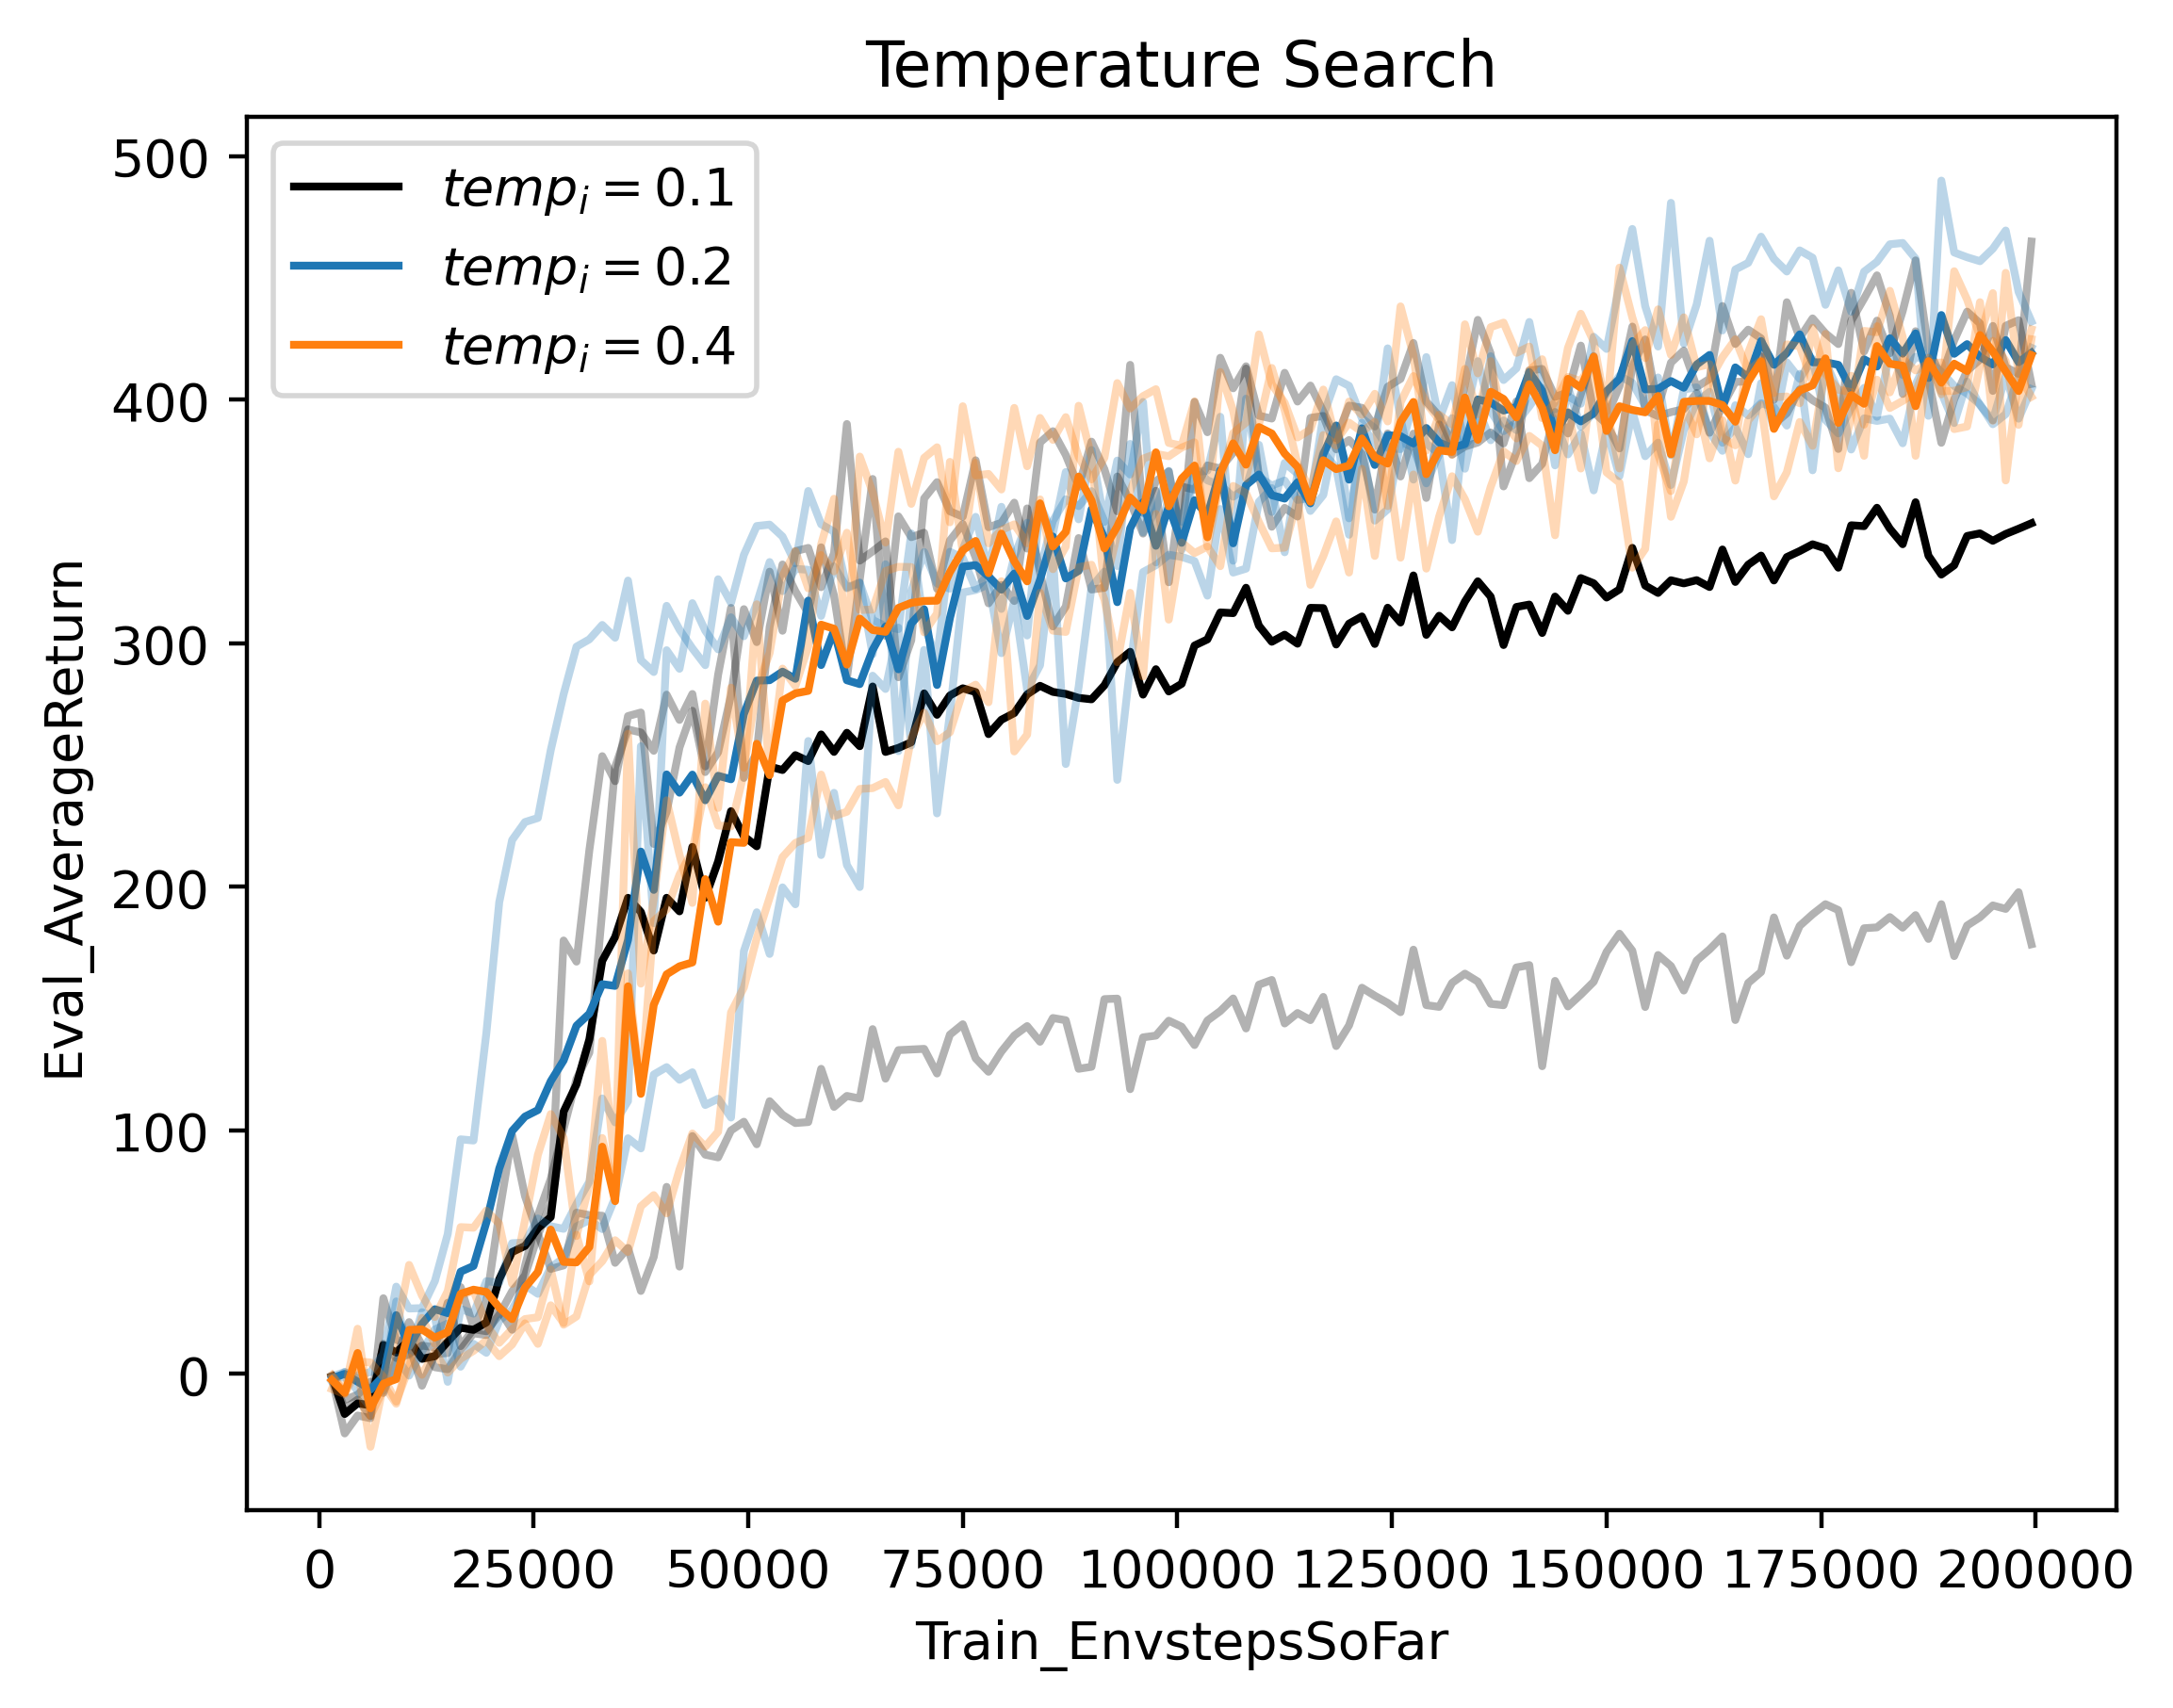

In [63]:
label_map = {
    peerv2_temp0p1: r"$temp_i = 0.1$",
    peerv2_temp0p2: r"$temp_i = 0.2$",
    peerv2_temp0p4: r"$temp_i = 0.4$",
    }

exp_names = [peerv2_temp0p1, peerv2_temp0p2, peerv2_temp0p4] # 

X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.2e6
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name or "ensemble" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        Y_avg = np.mean([Y for X, Y in series], axis=0)
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})
plt.title("Temperature Search")
plt.savefig("temp_search.png")
plt.show()

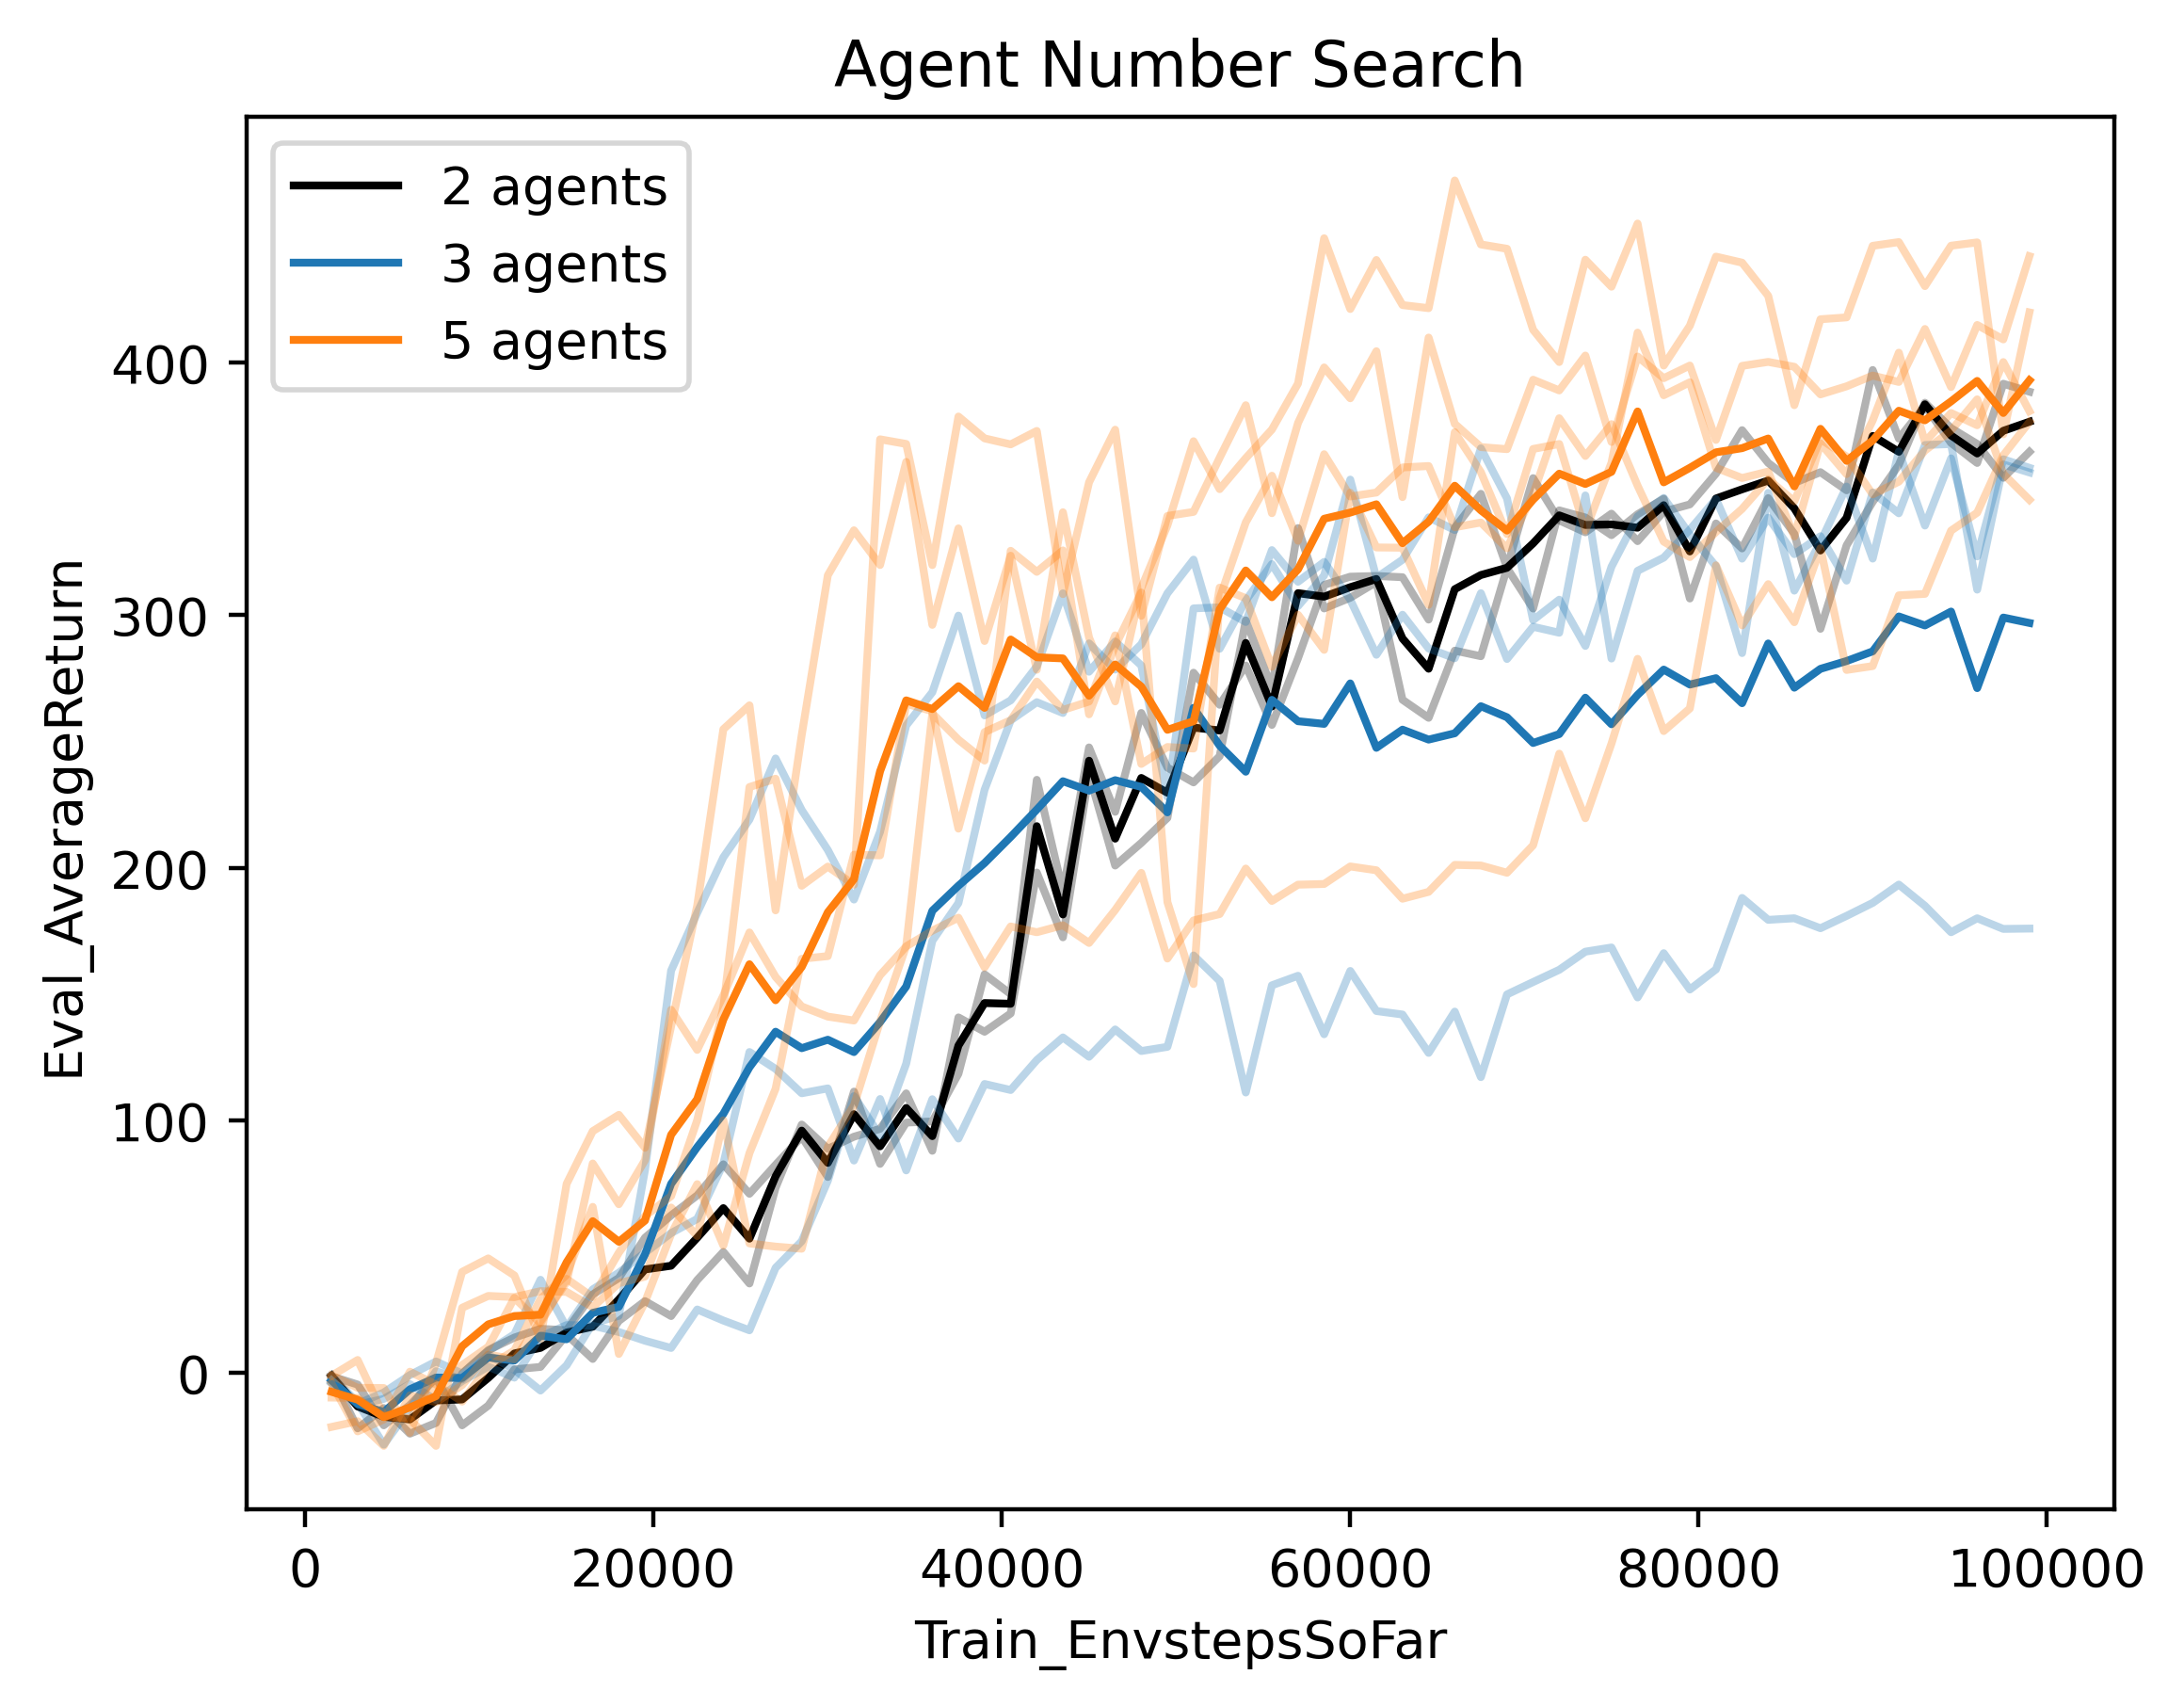

In [67]:
label_map = {
    default_2agents: r"2 agents",
    default_3agents: r"3 agents",
    default_5agents: r"5 agents",
    baseline: r"1 agent"
    }
exp_names = [default_2agents, default_3agents, default_5agents] # 

X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.1e6
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    elif "ensemble" in exp_name:
        series = getXYensemble(exp_name, X_label, Y_label, X_max=X_MAX)
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})
plt.title("Agent Number Search")
try:
    plt.savefig(f"agent_num_search_{int(X_MAX)}steps.png")
except(OverflowError):
    plt.savefig(f"agent_num_search.png")
    
plt.show()

# Performance Evaluation

In [69]:
label_map = {
    default_2agents: r"2 agents with advice ($\epsilon = 0.3$)",
    default_3agents: r"3 agents with advice ($\epsilon = 0.3$)",
    default_5agents: r"5 agents with advice ($\epsilon = 0.3$)",
    baseline: r"2 agents without advice ($\epsilon = 1$)", 
    ensemble2: r"2 agents vanilla ensemble bseline",
    ensemble3: r"3 agents vanilla ensemble bseline",
    ensemble5: r"5 agents vanilla ensemble bseline",
    }

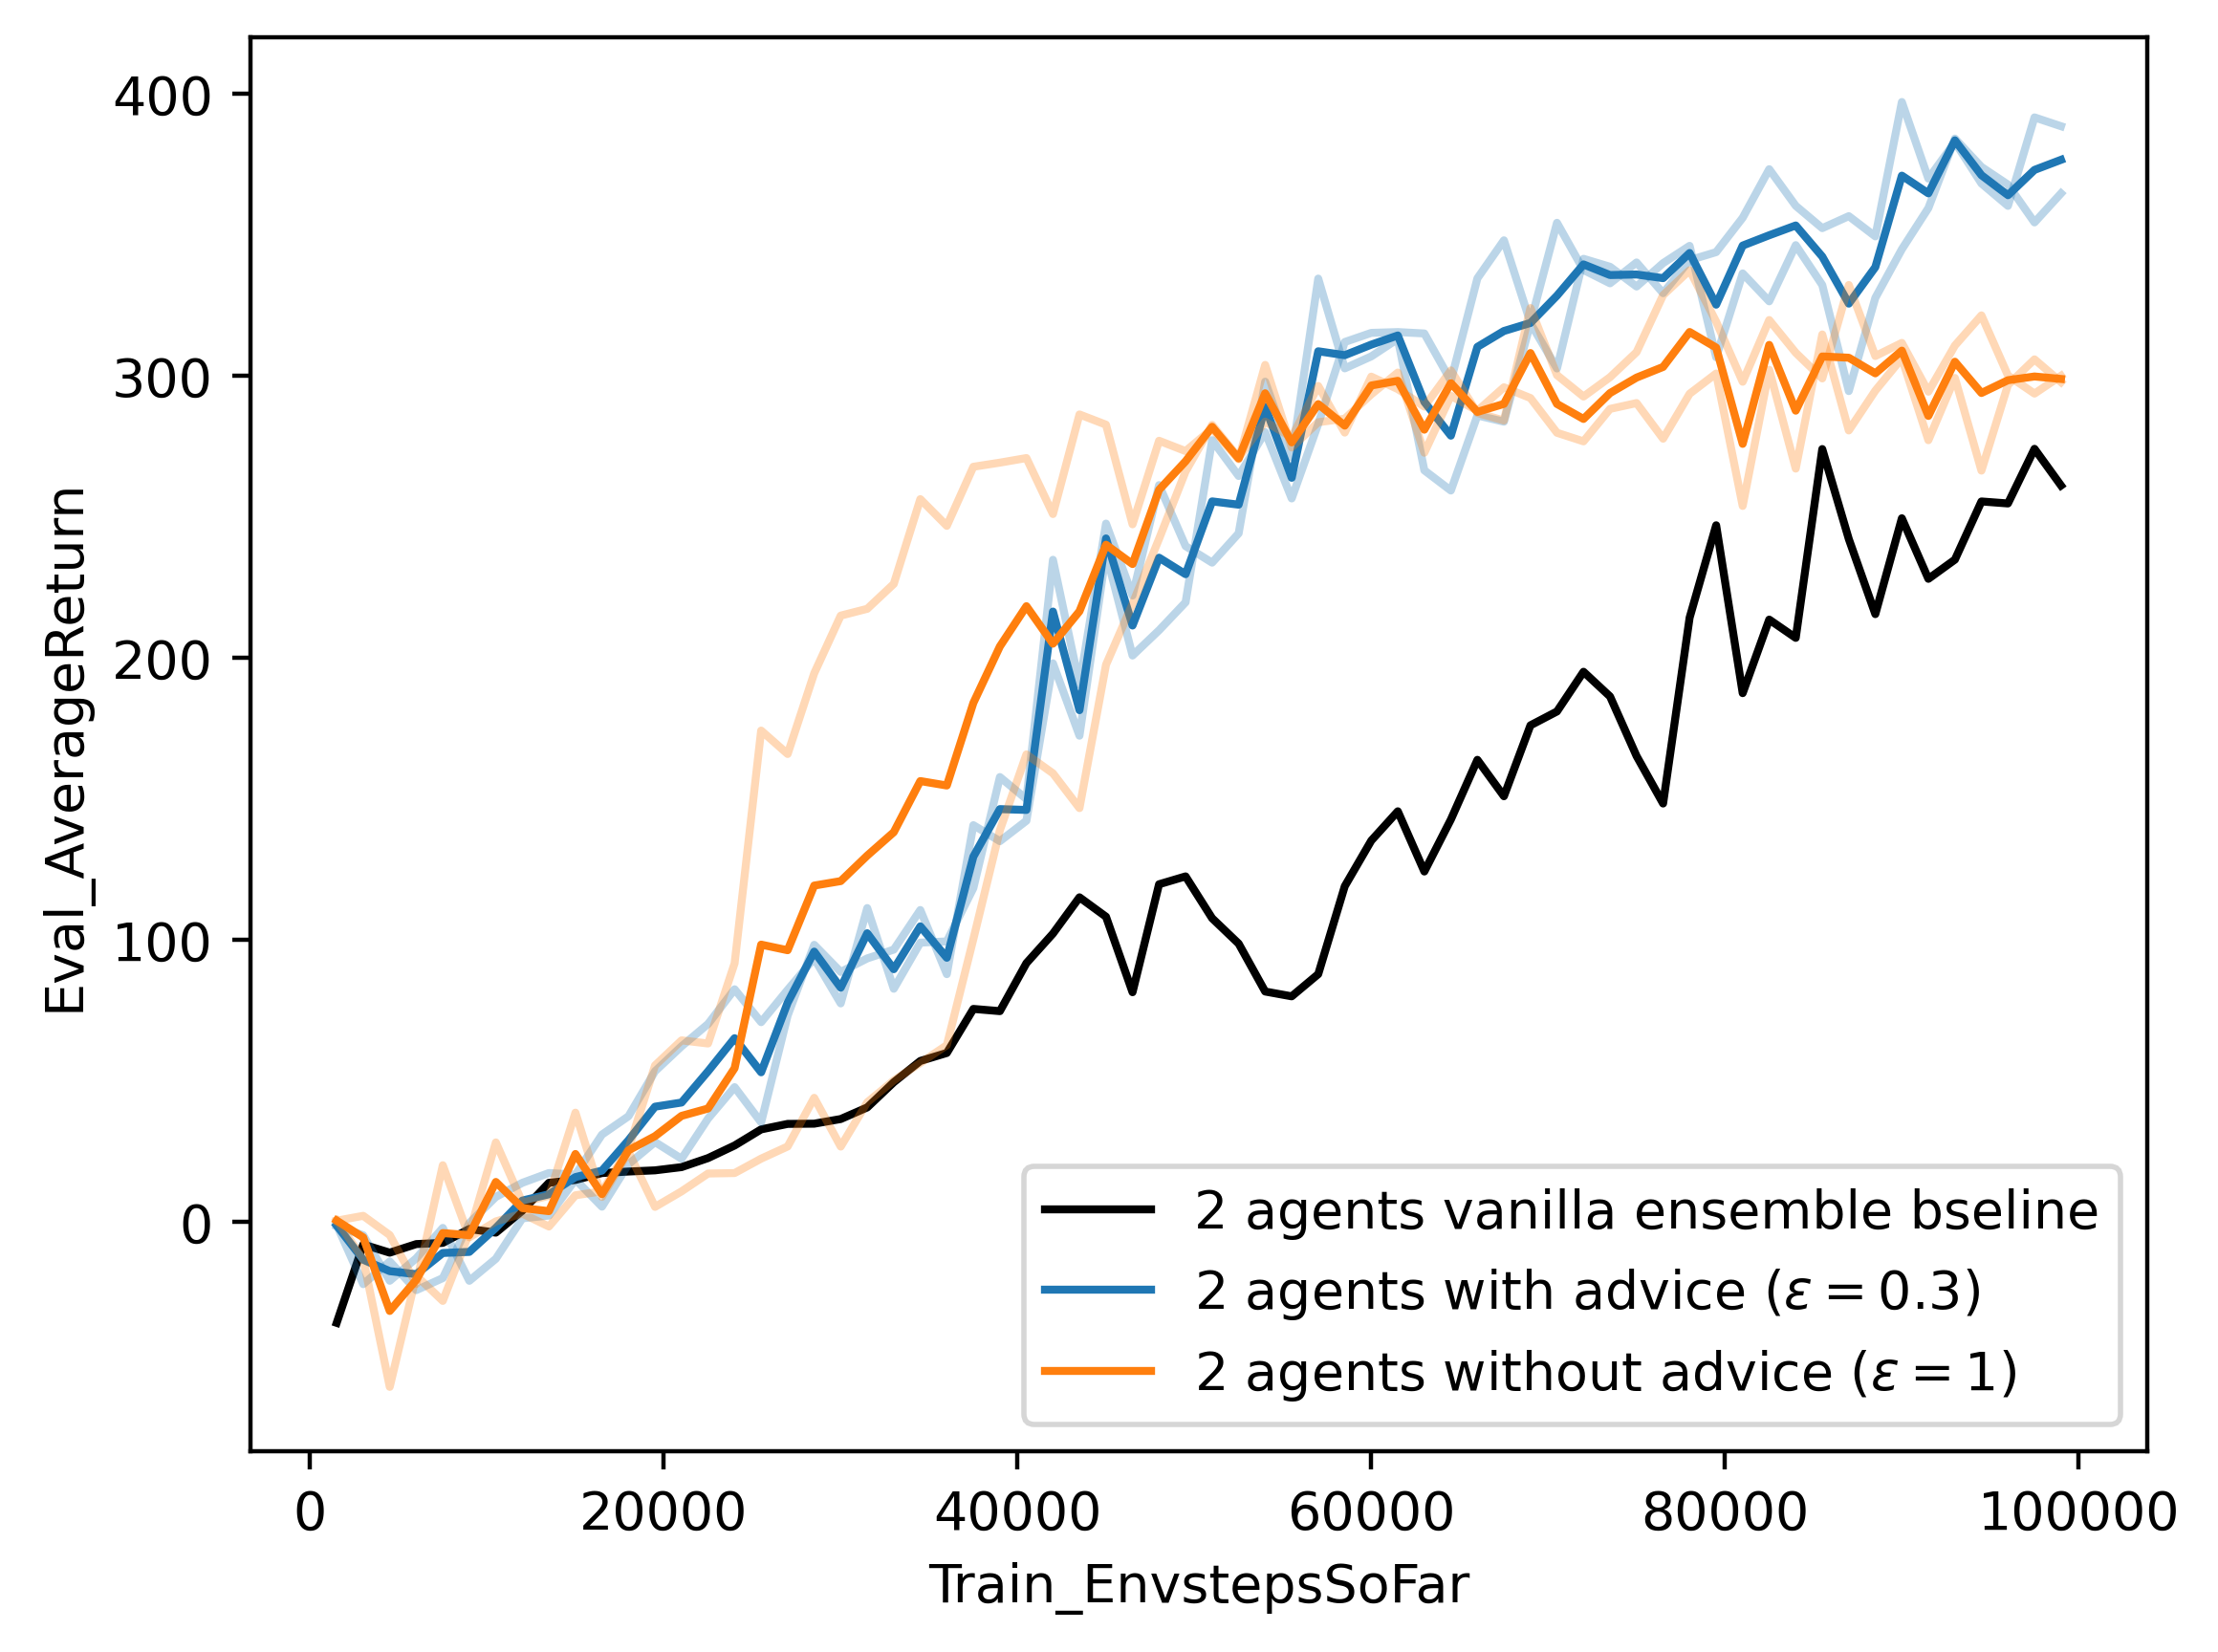

In [46]:
X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.1e6

exp_names = [ensemble2, default_2agents, baseline] # default_2agents, baseline
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    elif "ensemble" in exp_name:
        series = getXYensemble(exp_name, X_label, Y_label, X_max=X_MAX)
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})

name = "performance2"
try:
    plt.savefig(name + f"_{int(X_MAX)}steps.png")
except(OverflowError):
    plt.savefig(name + ".png")
    
plt.show()

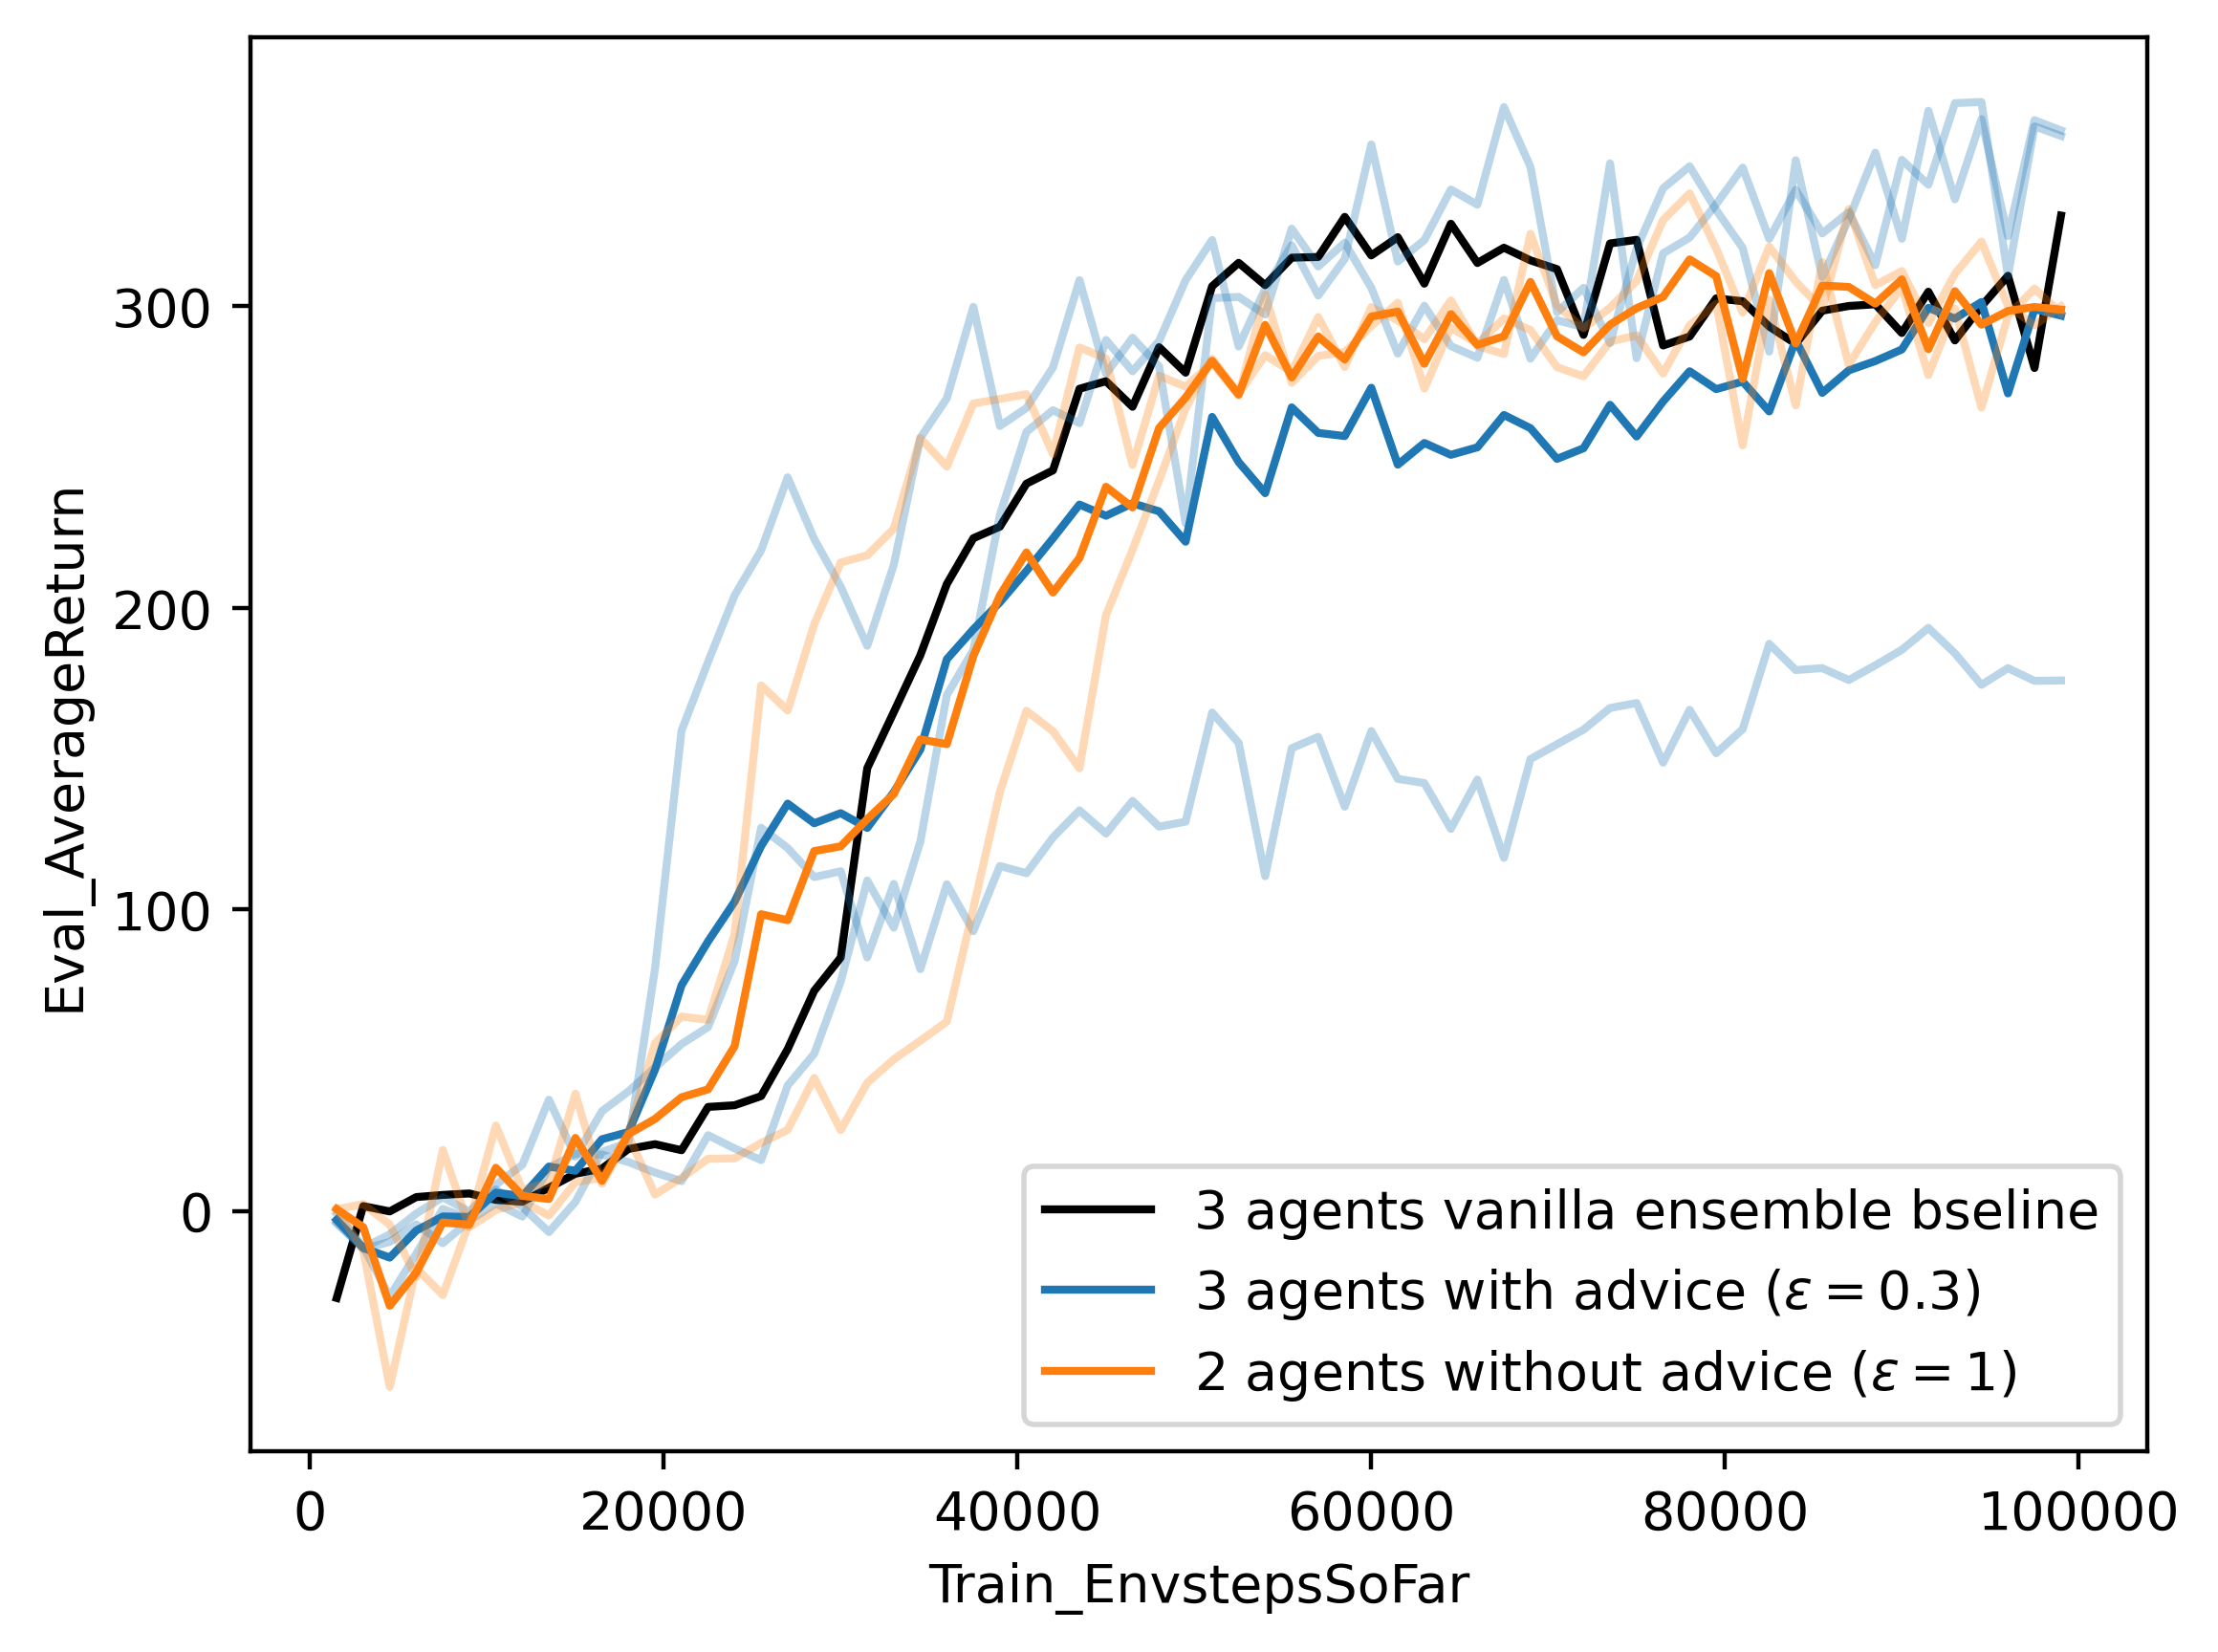

In [70]:
X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.1e6

exp_names = [ensemble3, default_3agents, baseline] # default_2agents, baseline
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    elif "ensemble" in exp_name:
        series = getXYensemble(exp_name, X_label, Y_label, X_max=X_MAX)
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})

name = "performance3"
try:
    plt.savefig(name + f"_{int(X_MAX)}steps.png")
except(OverflowError):
    plt.savefig(name + ".png")
    
plt.show()

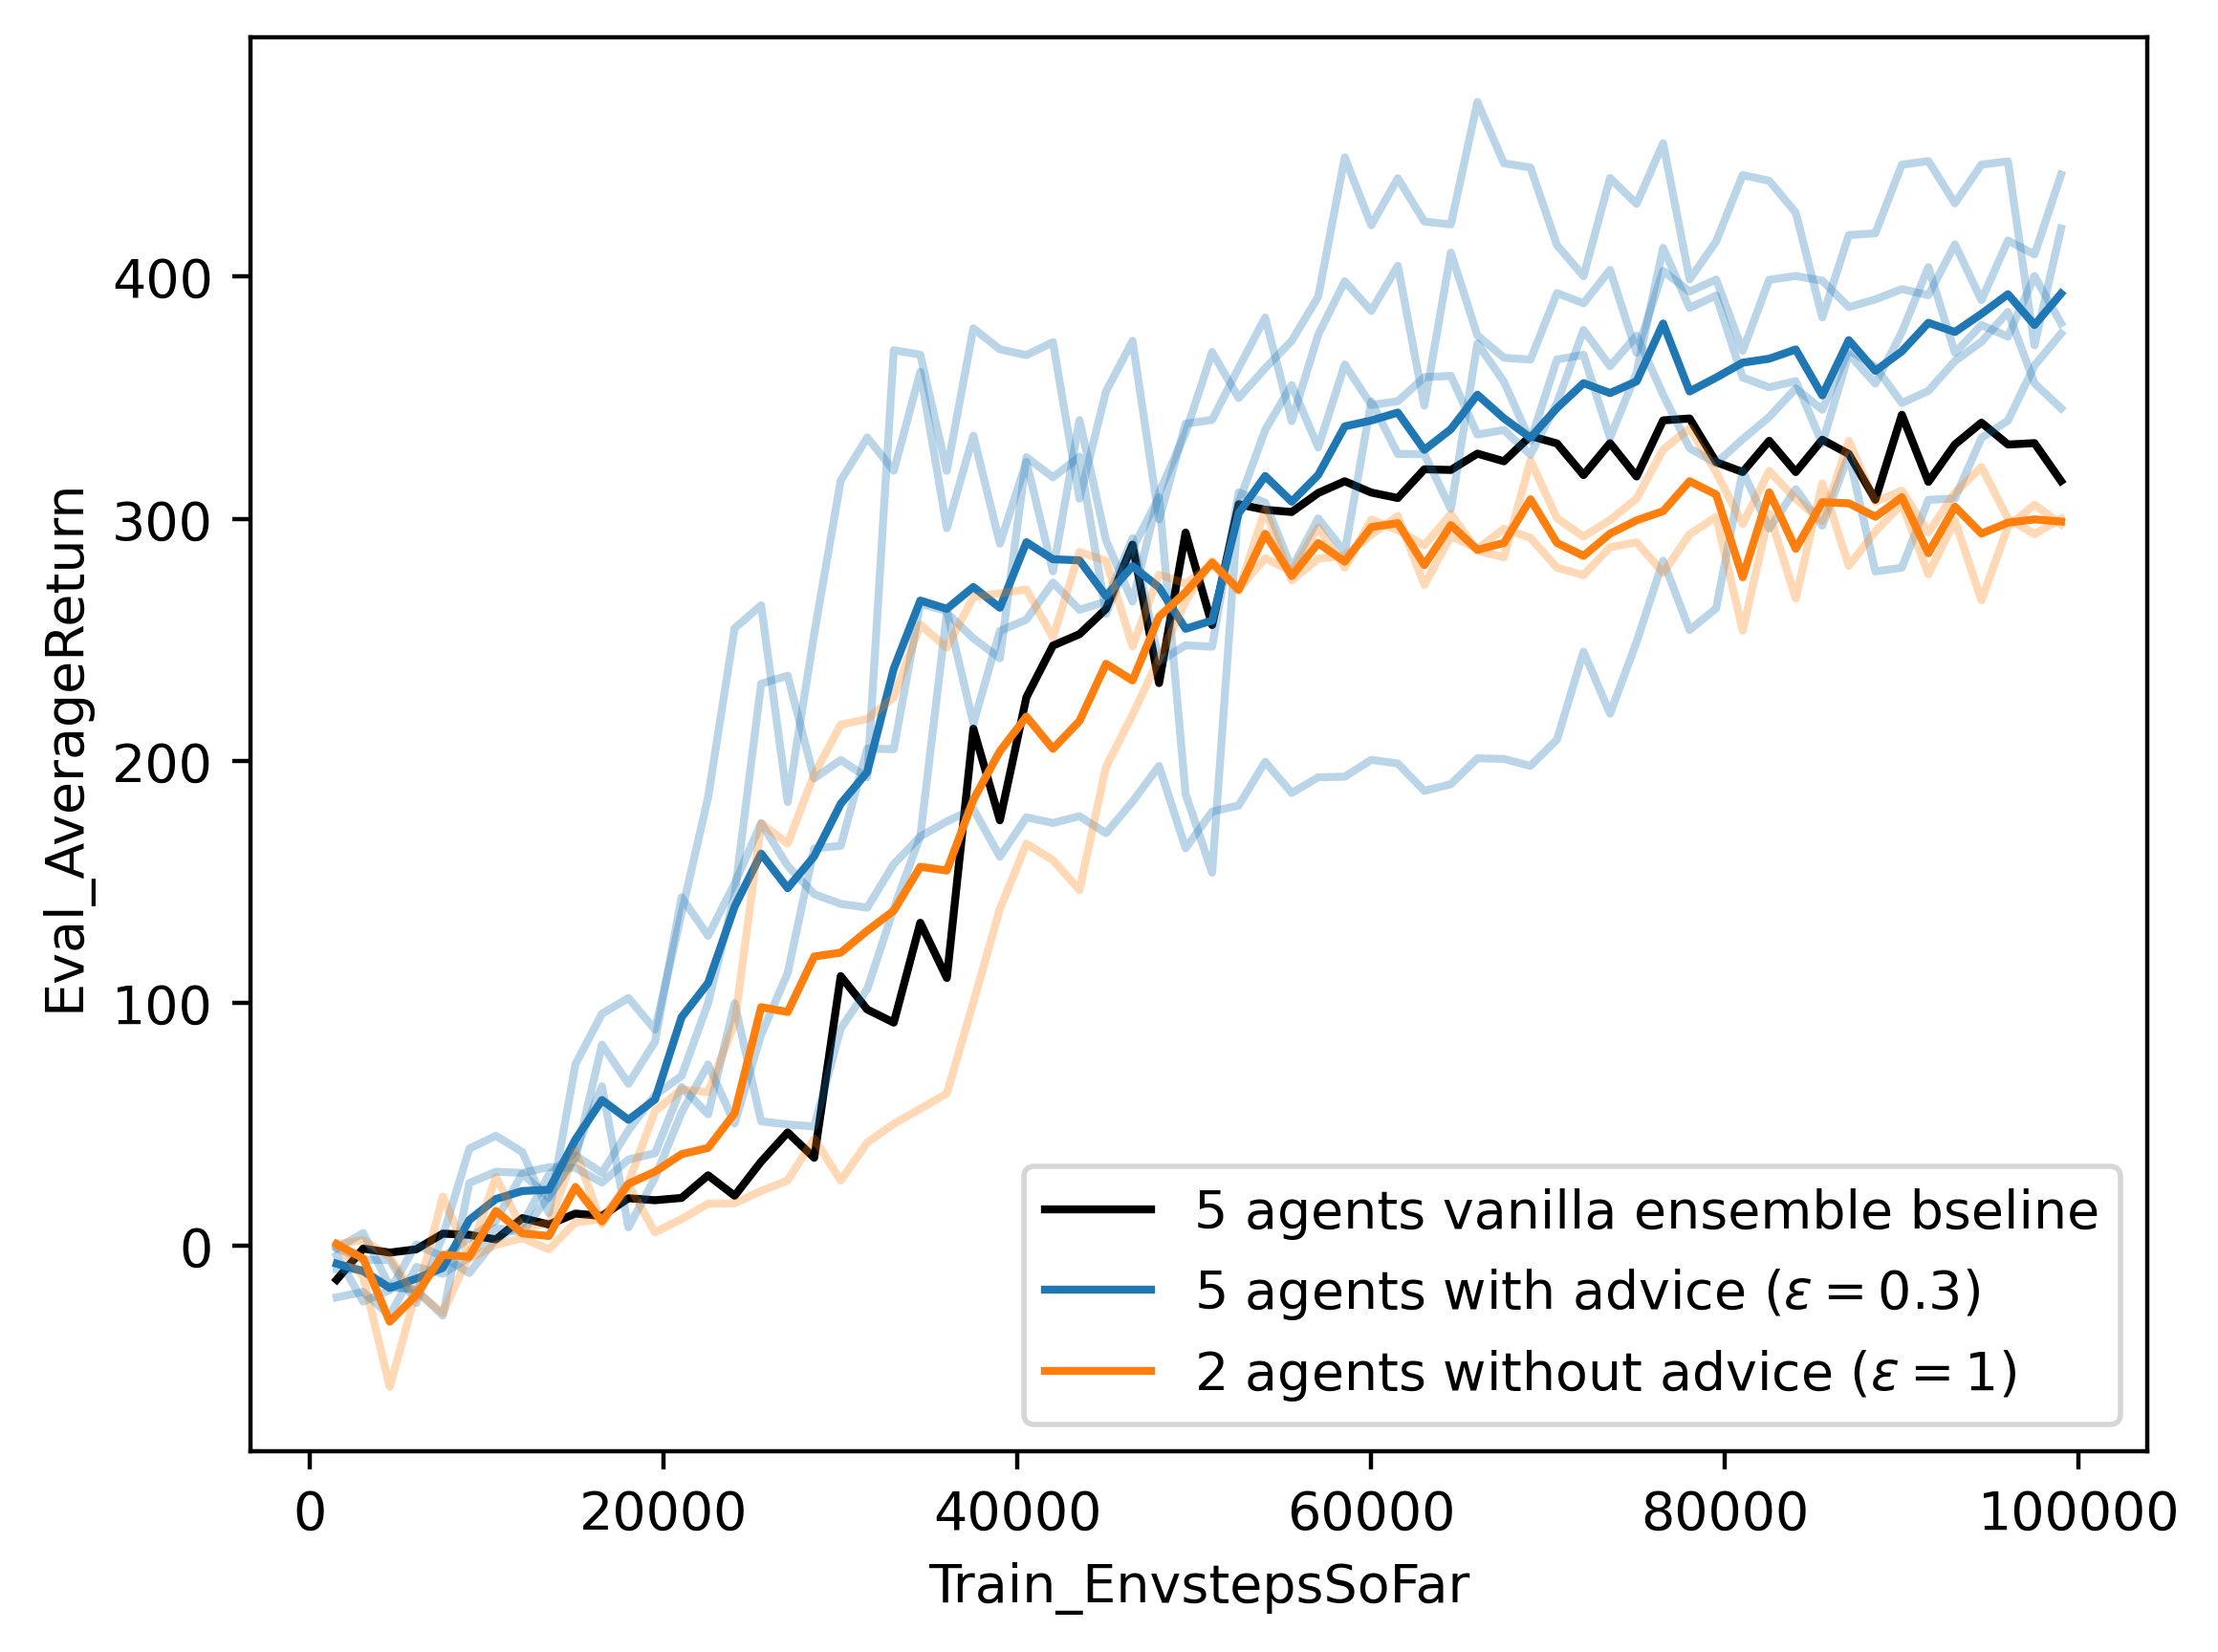

In [71]:
X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.1e6

exp_names = [ensemble5, default_5agents, baseline] # default_2agents, baseline
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    elif "ensemble" in exp_name:
        series = getXYensemble(exp_name, X_label, Y_label, X_max=X_MAX)
        min_len = min([len(X) for X, Y in series])
        Y_avg = np.mean([Y[:min_len] for X, Y in series], axis=0)
        X = X[:min_len]
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})

name = "performance5"
try:
    plt.savefig(name + f"_{int(X_MAX)}steps.png")
except(OverflowError):
    plt.savefig(name + ".png")
    
plt.show()

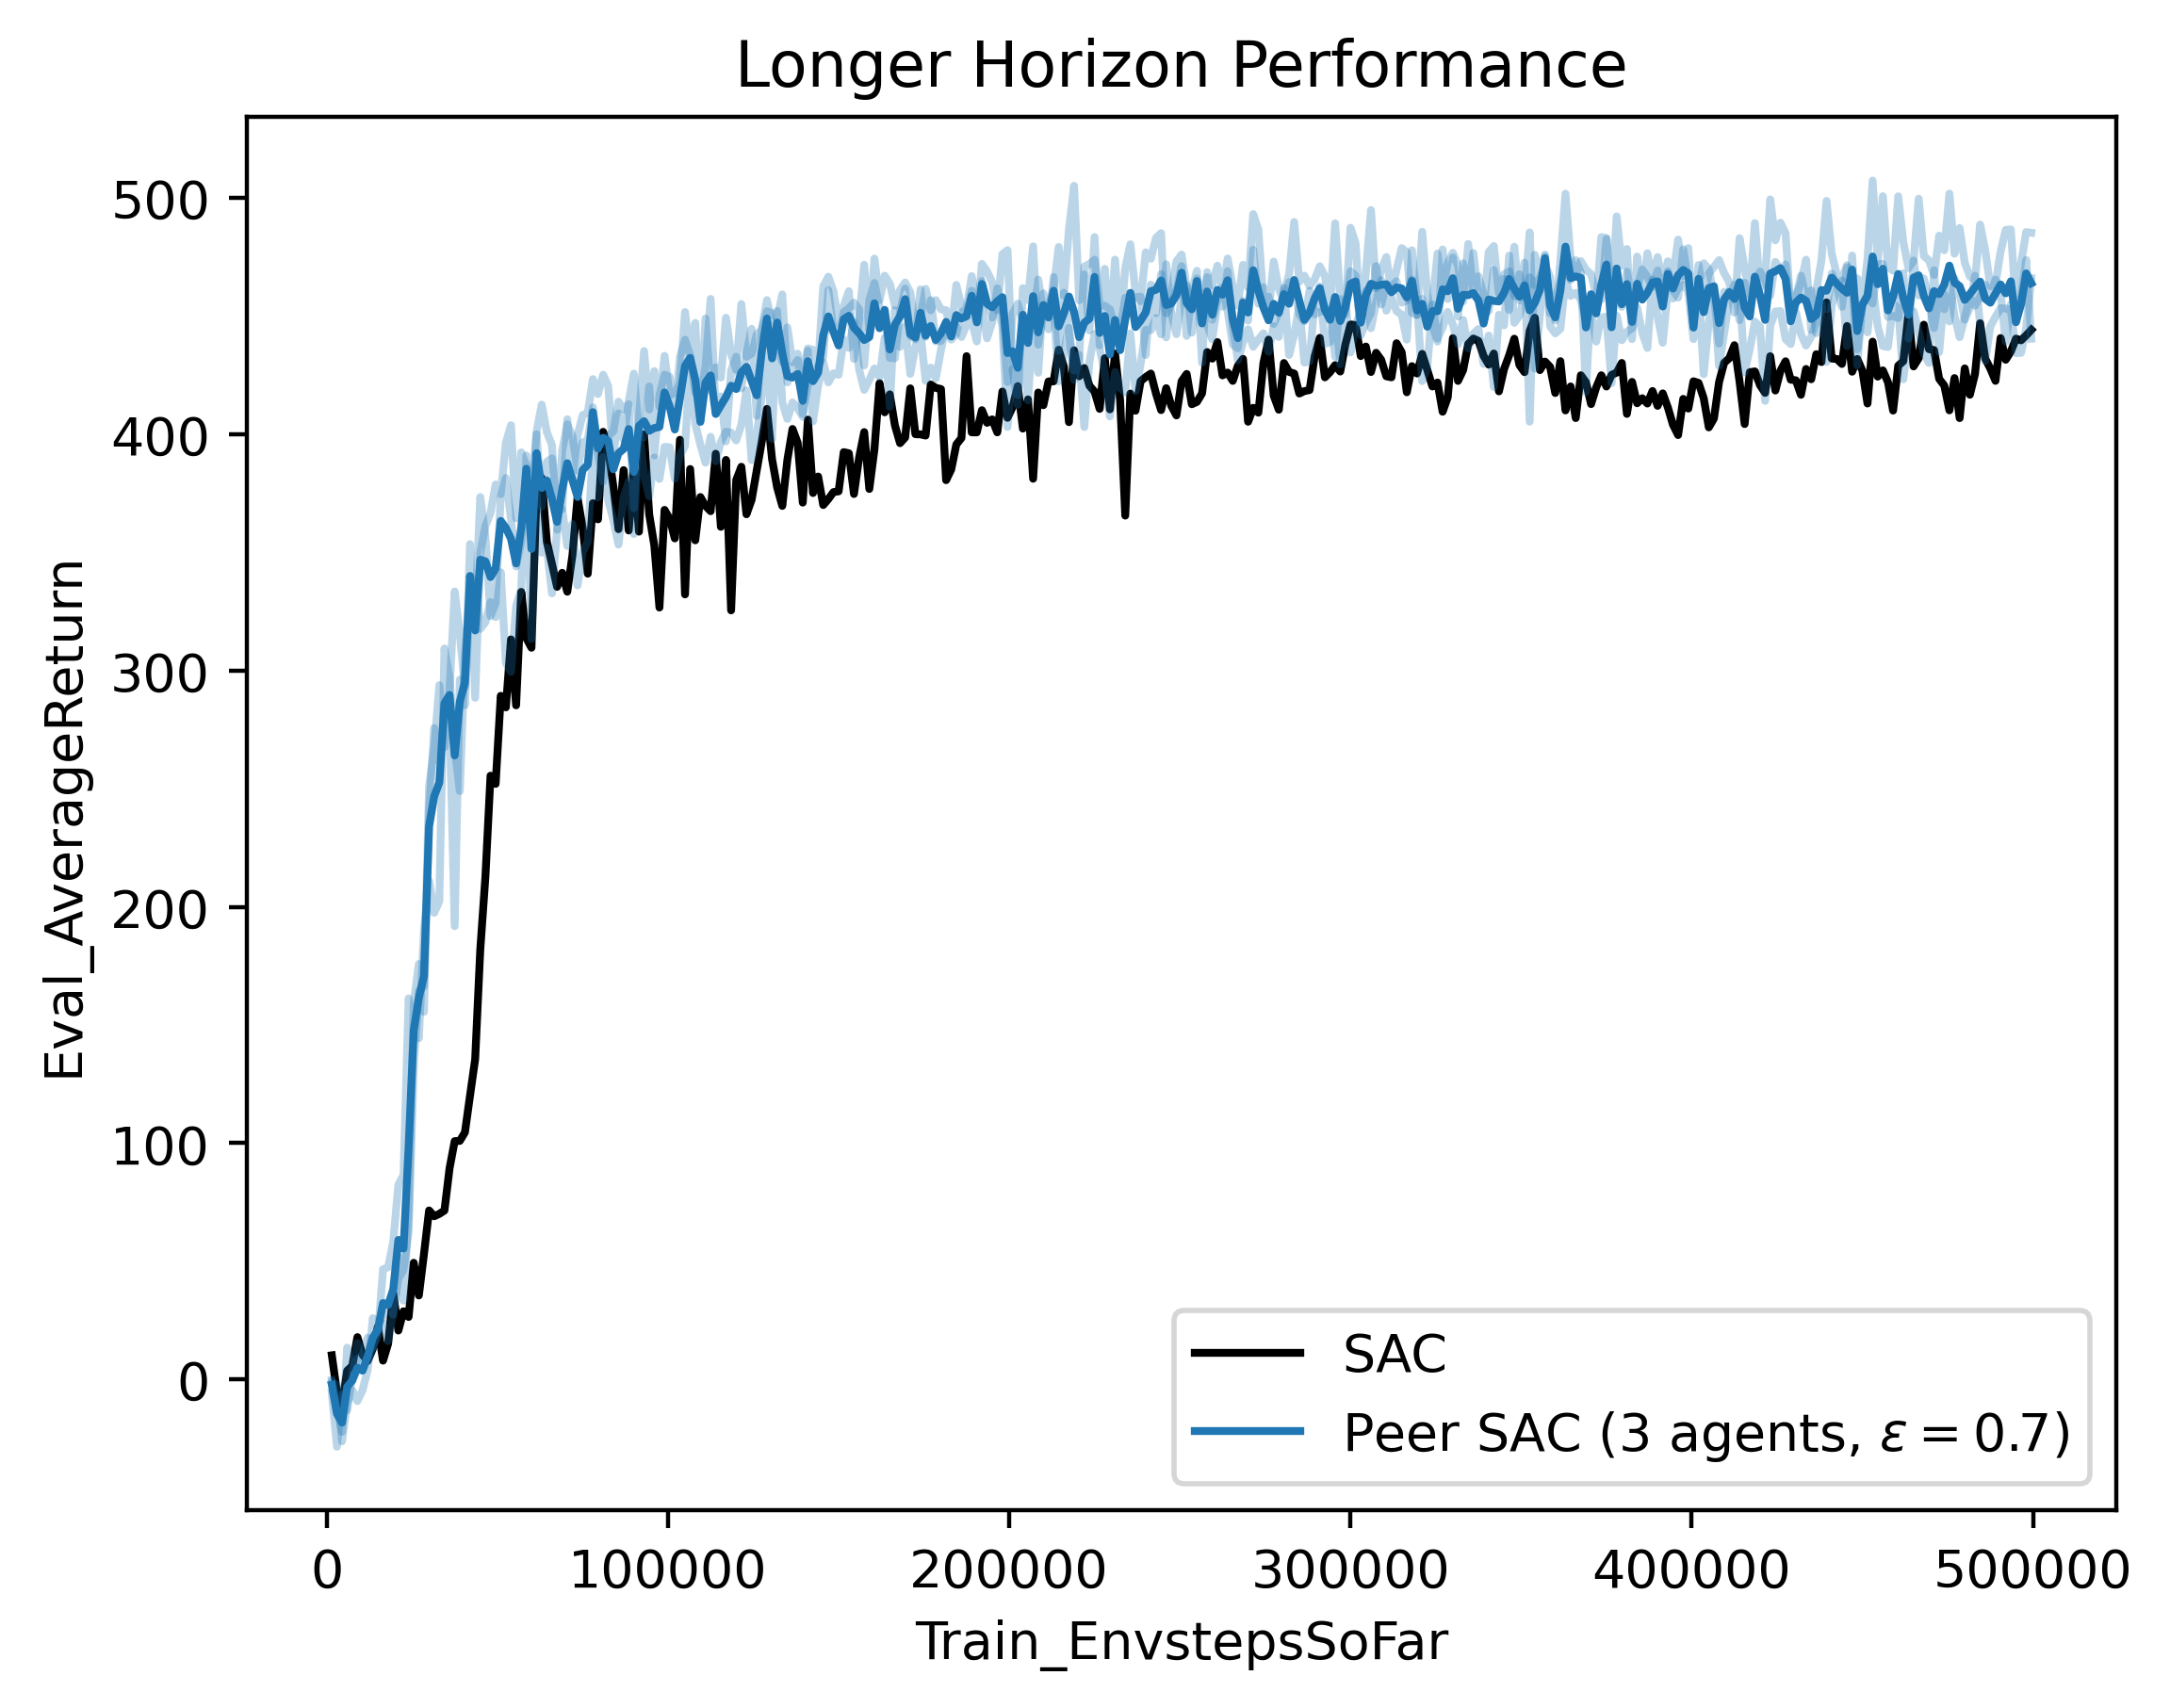

In [76]:
label_map = {
    hw3q6: r"SAC",
    peerv2_3agents_eps0p7: r"Peer SAC (3 agents, $\epsilon=0.7$)",
    }

exp_names = [hw3q6, peerv2_3agents_eps0p7] # 

X_label='Train_EnvstepsSoFar'
Y_label='Eval_AverageReturn'
X_MAX = float('inf')
X_MAX = 0.5e6
for ci, exp_name in enumerate(exp_names):
    if "peer" in exp_name or "ensemble" in exp_name:
        series = getXYpeer(exp_name, X_label, Y_label, X_max=X_MAX)
        for i in range(len(series)):
            X, Y = series[i]
            plt.plot(X, Y, alpha=0.3, c=colors[ci]) 
        Y_avg = np.mean([Y for X, Y in series], axis=0)
        plt.plot(X, Y_avg, label=label_map[exp_name], c=colors[ci]) 
    else:
        X, Y = getXY(exp_name, X_label, Y_label, X_max=X_MAX)
        plt.plot(X, Y, label=label_map[exp_name], c=colors[ci])
plt.xlabel(X_label)
plt.ylabel(Y_label)
plt.legend(prop={'size': 10})
plt.title("Longer Horizon Performance")
plt.savefig("performance_longterm.png")
plt.show()